In [4]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50, VGG19, MobileNet
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import cv2
import random

In [5]:
train_csv_path = '/kaggle/input/gtsrb-german-traffic-sign/Train.csv'
test_csv_path = '/kaggle/input/gtsrb-german-traffic-sign/Test.csv'

train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

print("Training Data:")
print(train_df.head())

print("\nTesting Data:")
print(test_df.head())

Training Data:
   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
0     27      26       5       5      22      20       20   
1     28      27       5       6      23      22       20   
2     29      26       6       5      24      21       20   
3     28      27       5       6      23      22       20   
4     28      26       5       5      23      21       20   

                             Path  
0  Train/20/00020_00000_00000.png  
1  Train/20/00020_00000_00001.png  
2  Train/20/00020_00000_00002.png  
3  Train/20/00020_00000_00003.png  
4  Train/20/00020_00000_00004.png  

Testing Data:
   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId            Path
0     53      54       6       5      48      49       16  Test/00000.png
1     42      45       5       5      36      40        1  Test/00001.png
2     48      52       6       6      43      47       38  Test/00002.png
3     27      29       5       5      22      24       33  Test/00003.png
4     60      57 

In [8]:
HEIGHT, WIDTH = 32, 32
NUM_CLASSES = 43

def preprocess_image(filepath, target_size=(HEIGHT, WIDTH)):
    img = cv2.imread(f'/kaggle/input/gtsrb-german-traffic-sign/{filepath}')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    return img / 255.0

images = np.array([preprocess_image(fp) for fp in train_df['Path']])
labels = to_categorical(train_df['ClassId'], NUM_CLASSES)

X_train, X_val, y_train, y_val = train_test_split(
    images, labels, test_size=0.2, random_state=42
)

print("Train:", X_train.shape)
print("Validation:", X_val.shape)

Training Data Shape: (31367, 32, 32, 3)
Validation Data Shape: (7842, 32, 32, 3)


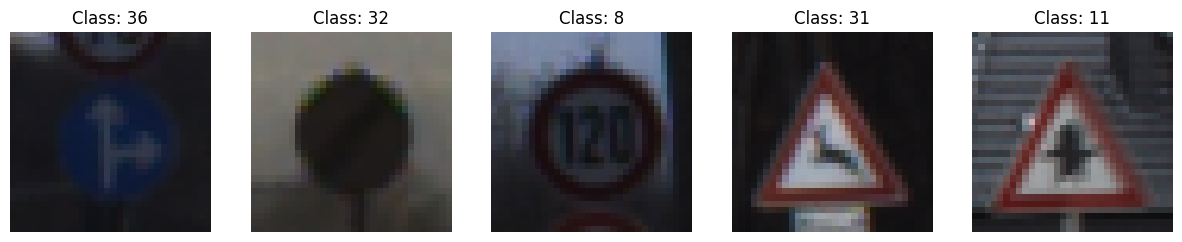

In [9]:
def show_random_samples(images, labels, n=5):
    fig, ax = plt.subplots(1, n, figsize=(15, 3))
    for i in range(n):
        index = random.randrange(len(images))
        ax[i].imshow(images[index])
        ax[i].set_title(f"Class: {np.argmax(labels[index])}")
        ax[i].axis("off")
    plt.tight_layout()
    plt.show()

show_random_samples(X_train, y_train)


In [11]:
def assess_model(model, X_eval, y_eval):
    loss, accuracy = model.evaluate(X_eval, y_eval, verbose=0)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    print(f"Test Loss: {loss:.4f}")

def visualize_training(history_obj):
    acc = history_obj.history['accuracy']
    val_acc = history_obj.history['val_accuracy']
    loss = history_obj.history['loss']
    val_loss = history_obj.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Train Acc')
    plt.plot(epochs, val_acc, label='Val Acc')
    plt.legend()
    plt.title('Accuracy Curve')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Val Loss')
    plt.legend()
    plt.title('Loss Curve')
    plt.tight_layout()
    plt.show()


In [15]:
vgg_base = VGG19(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
for layer in vgg_base.layers:
    layer.trainable = False

vgg_output = vgg_base.output
vgg_output = GlobalAveragePooling2D()(vgg_output)
vgg_output = Dense(512, activation='relu')(vgg_output)
vgg_output = Dropout(0.5)(vgg_output)
final_output = Dense(NUM_CLASSES, activation='softmax')(vgg_output)

vgg_model = Model(inputs=vgg_base.input, outputs=final_output)
vgg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
vgg_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,309,099 (77.47 MB)

 Trainable params: 284,715 (1.09 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [16]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0.8, 1.2),
    zoom_range=0.1
)
datagen.fit(X_train)

cb_earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
cb_reducelr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

history_augmented = vgg_model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=15,
    callbacks=[cb_earlystop, cb_reducelr]
)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


981/981 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.2581 - loss: 2.6322 - val_accuracy: 0.4550 - val_loss: 1.7177 - learning_rate: 0.0010
Epoch 2/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.4244 - loss: 1.8544 - val_accuracy: 0.5499 - val_loss: 1.4627 - learning_rate: 0.0010
Epoch 3/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.4751 - loss: 1.6667 - val_accuracy: 0.5581 - val_loss: 1.3859 - learning_rate: 0.0010
Epoch 4/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.5052 - loss: 1.5573 - val_accuracy: 0.5974 - val_loss: 1.2844 - learning_rate: 0.0010
Epoch 5/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.5244 - loss: 1.4960 - val_accuracy: 0.6262 - val_loss: 1.1860 - learning_rate: 0.0010
Epoch 6/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.5346 - loss: 1.4366 - val_accuracy: 0.6187 - val_loss: 1.1631 - learning_rate: 0.0010
Epoch 7/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.5518 - loss: 1.3948

In [17]:
assess_model(vgg_model, X_val, y_val)


Test Accuracy: 71.32%
Test Loss: 0.8762


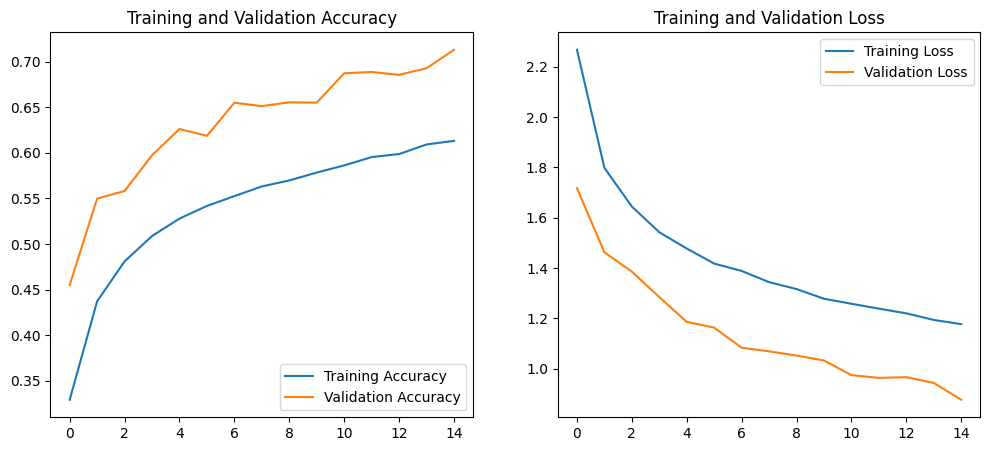

In [18]:
visualize_training(history_augmented)

In [19]:
pretrained_core = VGG19(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

for layer in pretrained_core.layers:
    layer.trainable = False

z = pretrained_core.output
z = GlobalAveragePooling2D()(z)
z = Dense(512, activation='relu')(z)
z = Dropout(0.5)(z)
out_layer = Dense(NUM_CLASSES, activation='softmax')(z)

vgg19_static = Model(inputs=pretrained_core.input, outputs=out_layer)

vgg19_static.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

vgg19_static.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,309,099 (77.47 MB)

 Trainable params: 284,715 (1.09 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [20]:
cb_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
cb_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

training_trace = vgg19_static.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=32,
    callbacks=[cb_early, cb_reduce]
)

Epoch 1/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.2983 - loss: 2.4655 - val_accuracy: 0.5247 - val_loss: 1.5497 - learning_rate: 0.0010
Epoch 2/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.4990 - loss: 1.5955 - val_accuracy: 0.6136 - val_loss: 1.2700 - learning_rate: 0.0010
Epoch 3/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.5675 - loss: 1.3636 - val_accuracy: 0.6530 - val_loss: 1.1231 - learning_rate: 0.0010
Epoch 4/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.6080 - loss: 1.2098 - val_accuracy: 0.6623 - val_loss: 1.0465 - learning_rate: 0.0010
Epoch 5/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.6419 - loss: 1.1195 - val_accuracy: 0.7085 - val_loss: 0.9512 - learning_rate: 0.0010
Epoch 6/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.6626 - loss: 1.0431 - val_accuracy: 0.7228 - val_loss: 0.8805 - learning_rate: 0.0010
Epoch 7/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.6817 - loss: 0.9832 

In [21]:
evaluate_model(vgg19_static, X_val, y_val)

Test Accuracy: 81.48%
Test Loss: 0.5933


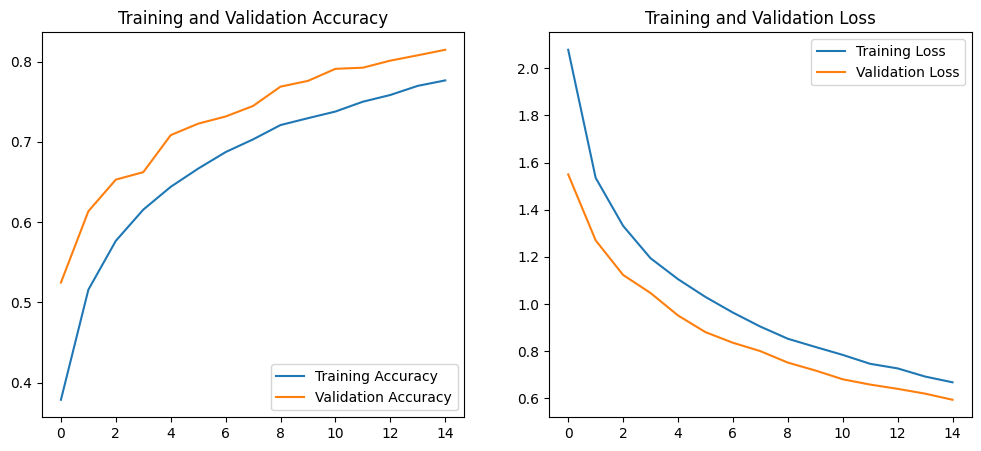

In [22]:
plot_training_curves(training_trace)

In [ ]:
for layer in pretrained_core.layers[-8:]:
    layer.trainable = True

vgg19_finetuned = Model(inputs=pretrained_core.input, outputs=out_layer)
vgg19_finetuned.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [24]:
history_vgg19_finetuned = vgg19_finetuned.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 27s 23ms/step - accuracy: 0.7771 - loss: 0.6571 - val_accuracy: 0.8332 - val_loss: 0.4967 - learning_rate: 1.0000e-05
Epoch 2/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.8518 - loss: 0.4316 - val_accuracy: 0.8914 - val_loss: 0.3454 - learning_rate: 1.0000e-05
Epoch 3/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.8818 - loss: 0.3484 - val_accuracy: 0.9007 - val_loss: 0.3054 - learning_rate: 1.0000e-05
Epoch 4/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.9089 - loss: 0.2715 - val_accuracy: 0.9102 - val_loss: 0.2752 - learning_rate: 1.0000e-05
Epoch 5/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.9207 - loss: 0.2377 - val_accuracy: 0.9329 - val_loss: 0.2186 - learning_rate: 1.0000e-05
Epoch 6/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - accuracy: 0.9363 - loss: 0.1895 - val_accuracy: 0.9334 - val_loss: 0.2137 - learning_rate: 1.0000e-05
Epoch 7/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/ste

In [25]:
evaluate_model(vgg19_finetuned, X_val, y_val)

Test Accuracy: 96.77%
Test Loss: 0.1084


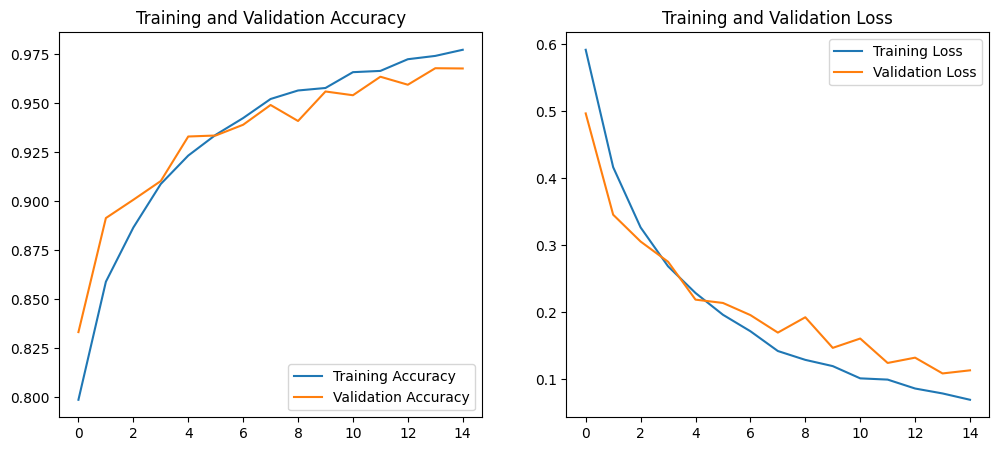

In [26]:
plot_training_curves(history_vgg19_finetuned)

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def build_lenet(shape=(32, 32, 3), classes=43):
    model = Sequential([
        Conv2D(6, (5, 5), activation='relu', input_shape=shape),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(16, (5, 5), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(120, activation='relu'),
        Dense(84, activation='relu'),
        Dropout(0.5),
        Dense(classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

lenet_net = build_lenet()
lenet_net.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 6)           │             456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 6)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 10, 10, 16)          │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 5, 5, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 400)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 120)                 │          48,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 84)                  │          10,164 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 84)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 43)                  │           3,655 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 64,811 (253.17 KB)

 Trainable params: 64,811 (253.17 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

history_lenet = lenet_net.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=32,
    callbacks=[stop_early, lr_scheduler]
)

Epoch 1/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.3088 - loss: 2.5558 - val_accuracy: 0.8544 - val_loss: 0.5592 - learning_rate: 0.0010
Epoch 2/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7957 - loss: 0.6732 - val_accuracy: 0.9023 - val_loss: 0.3387 - learning_rate: 0.0010
Epoch 3/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8824 - loss: 0.3825 - val_accuracy: 0.9462 - val_loss: 0.1910 - learning_rate: 0.0010
Epoch 4/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9217 - loss: 0.2637 - val_accuracy: 0.9672 - val_loss: 0.1296 - learning_rate: 0.0010
Epoch 5/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9408 - loss: 0.1941 - val_accuracy: 0.9739 - val_loss: 0.0983 - learning_rate: 0.0010
Epoch 6/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9569 - loss: 0.1489 - val_accuracy: 0.9742 - val_loss: 0.0981 - learning_rate: 0.0010
Epoch 7/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9600 - loss: 0.1335 - 

In [30]:
evaluate_model(lenet_net, X_val, y_val)

Test Accuracy: 98.76%
Test Loss: 0.0591


In [ ]:
val_acc_aug = max(history_augmented.history['val_accuracy'])
val_acc_base = max(training_trace.history['val_accuracy'])
val_acc_finetune = max(history_vgg19_finetuned.history['val_accuracy'])
val_acc_lenet = max(history_lenet.history['val_accuracy'])